In [1]:
%load_ext autoreload
%load_ext line_profiler

In [2]:
import sys
sys.path.append('../../') #takes us to the directory named foreground_functions that housed the foreground_function.py 
#and the w3j.npy files

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize

Populating the interactive namespace from numpy and matplotlib


# Foreground parameters

In [3]:
#the parameters chosen here (except gamma) are from the BICEP 2018 paper. The alphas differ by addition of 2, as we've
#calculated the C_ells, while the BICEP paper models the D_ells. The amplitudes also have had to be scaled to pivot
#frequency of 95 GHz so differ by a factor (95/original pivot)^beta
A_s_BICEP = 1.0 #micro K^2
A_d_BICEP = 4.6 #micro K^2
alpha_s_BICEP = -0.6
alpha_d_BICEP = -0.4


alpha_s = alpha_s_BICEP - 2 #convert from D_ells to C_ells (ish)
beta_s = -3.1
gamma_s = -2.5
A_s = A_s_BICEP * (ff.scale_synch(95e9, beta_s)/ff.scale_synch(23e9, beta_s))**2 * 2*pi/(80*81) # scale to new frequency and convert from D_ells to C_ells
A_s = A_s[0]
params_s = [A_s, alpha_s, beta_s, gamma_s]
alpha_d = alpha_s_BICEP - 2 #convert from D_ells to C_ells (ish)
beta_d = 1.6
gamma_d = -3.5
A_d = A_d_BICEP * (ff.scale_synch(95e9, beta_d)/ff.scale_synch(395e9, beta_d))**2 * 2*pi/(80*81) # scale to new frequency and convert from D_ells to C_ells
A_d = A_d[0]
params_d = [A_d, alpha_d, beta_d, gamma_d] 

params = params_s + params_d

nside=128
ells = np.arange(384)
freqs = np.array([30, 60, 95, 120, 150, 180, 210, 230, 260, 290])*1.e9 

In [4]:
print(A_s, A_d)

2.2573626192909638e-07 1.5723188445215814e-07


# CMB data

In [5]:
#the D_ells of the CMB with r=0.01
camb_lens_r1 = loadtxt('../../power_spectra/camb_lens_r1.dat').T
camb_lens_nobb = loadtxt('../../power_spectra/camb_lens_nobb.dat').T
primo_bb = camb_lens_r1[3]
lens_bb = camb_lens_nobb[3]
r = 0.01
bb_001 = (r * primo_bb + lens_bb)[:384]
bb_01 = (0.1 * primo_bb + lens_bb)[:384]
bb_1   = (primo_bb + lens_bb)[:384]

In [6]:
data_synch = ff.const_ps_data_synch(ells, freqs, params_s)
data_dust = ff.const_ps_data_dust(ells, freqs, params_d)
data_fg = ff.const_ps_data_fg(ells, freqs, params)

In [7]:
signal = data_fg + bb_001

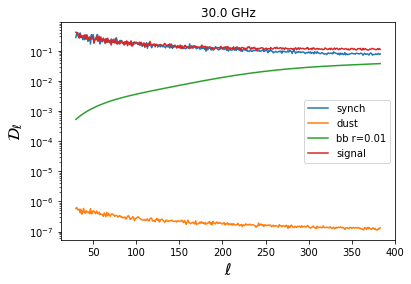

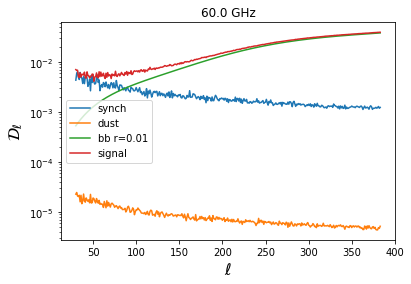

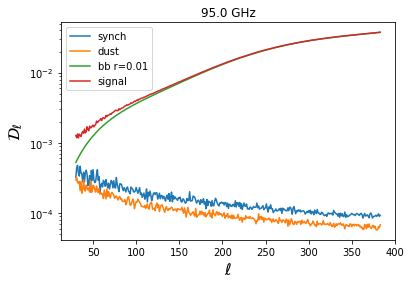

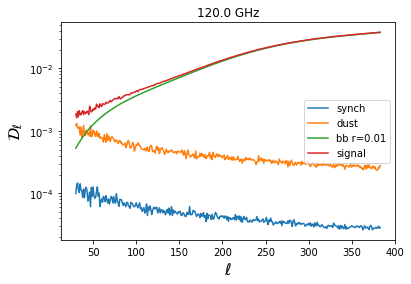

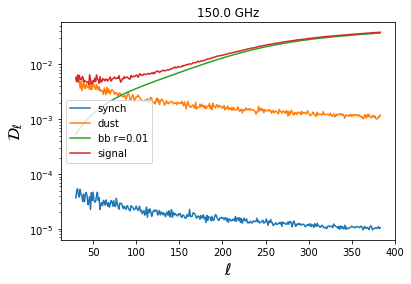

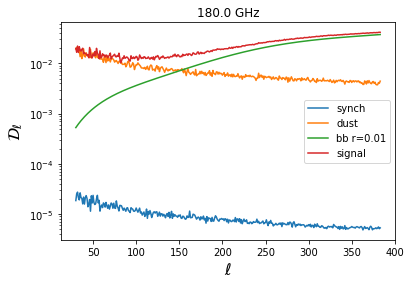

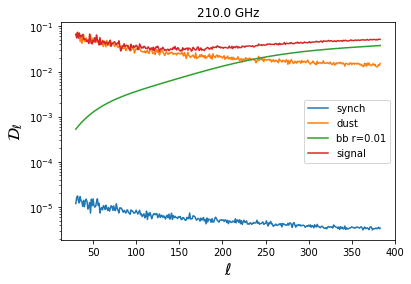

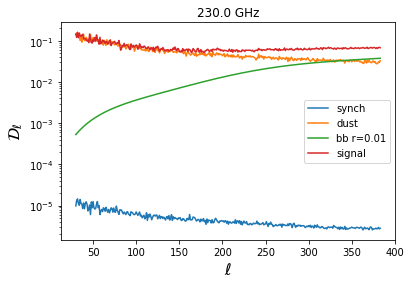

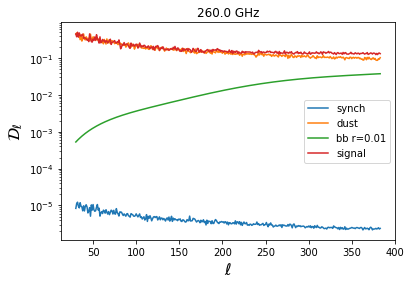

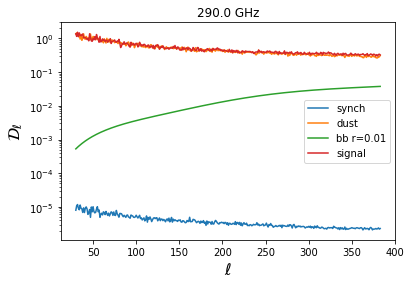

In [8]:
for i in range(len(freqs)):
    figure()
    semilogy(ells[30:], data_synch[i][30:], label='synch')
    semilogy(ells[30:], data_dust[i][30:], label='dust')
    semilogy(ells[30:], bb_001[30:], label='bb r=0.01')
    semilogy(ells[30:], signal[i][30:], label='signal')
#     semilogy(ells[30:], bb_01[30:], label='bb r=0.1')
#     semilogy(ells[30:], bb_1[30:], label='bb r=1')
#     semilogy(ells[30:], data_fg[i][30:], label='foreground')
    freq = freqs[i]*1e-9
    title(f'{freq:.4} GHz')
    ylabel(r'$\mathcal{D}_\ell$', fontsize=16)
    xlabel(r'$\ell$', fontsize=16)
    legend()

# Test what the amplitude maps are doing

In [36]:
ampmap_s = ff.map_amp(ells, params_s[:2])
ampmap_d = ff.map_amp(ells, params_d[:2])

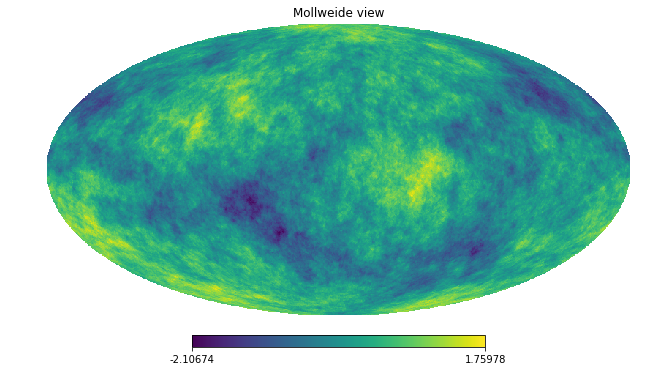

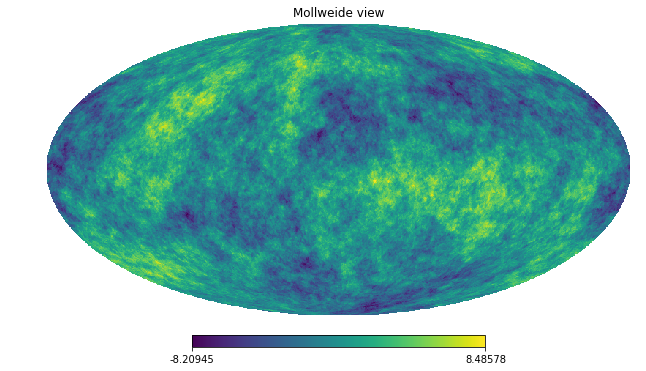

In [37]:
hp.mollview(ampmap_s)
hp.mollview(ampmap_d)

In [25]:
%autoreload

In [38]:
newmap_s = ff.map_const_beta_synch(ells, freqs, params_s[:3])
newmap_d = ff.map_const_beta_dust(ells, freqs, params_d[:3])

In [39]:
newmap_s.shape

(10, 196608)

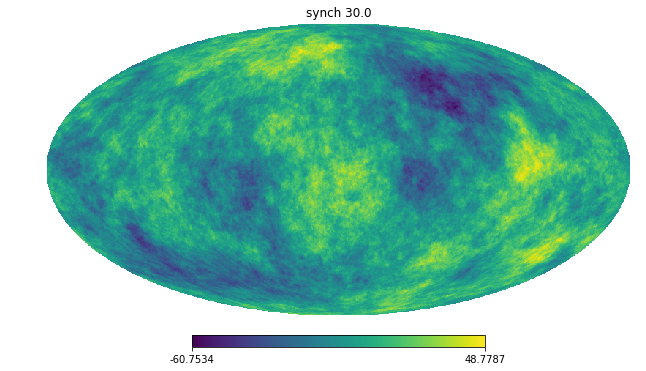

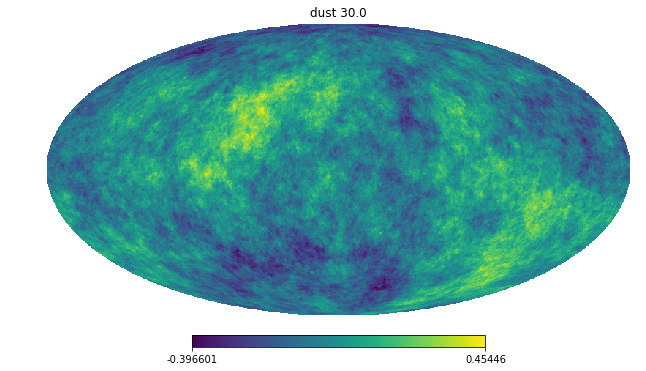

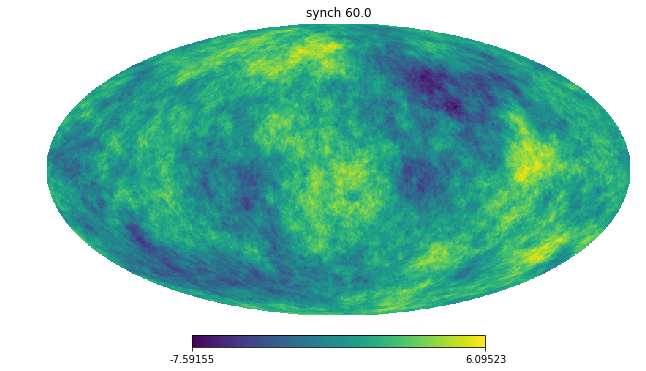

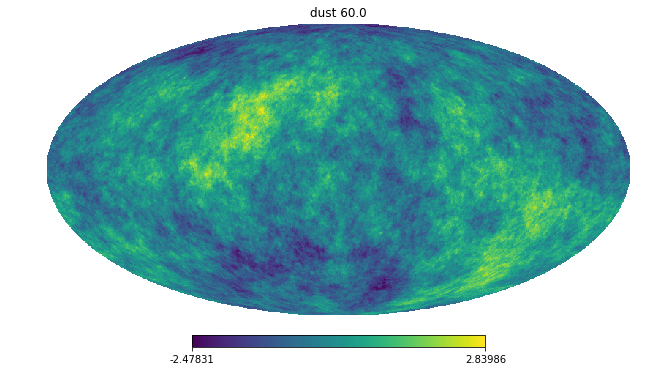

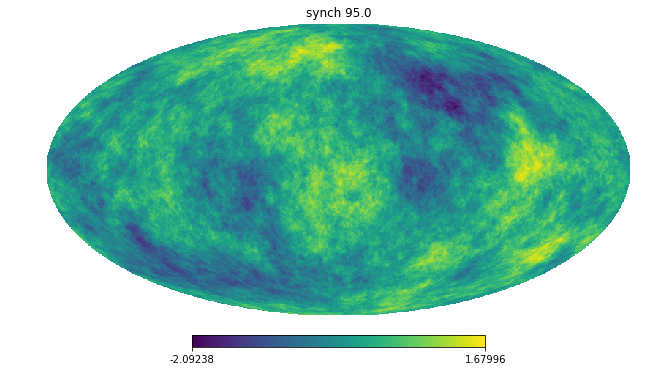

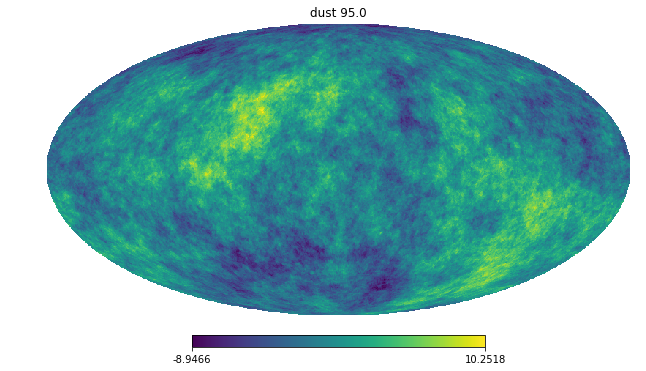

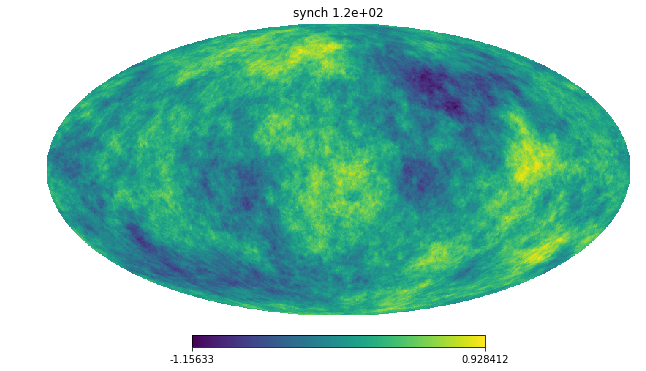

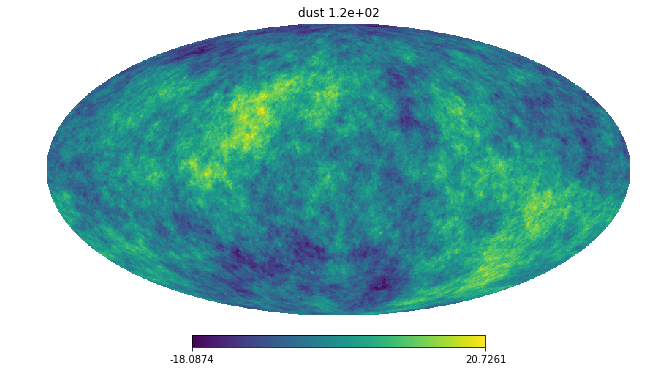

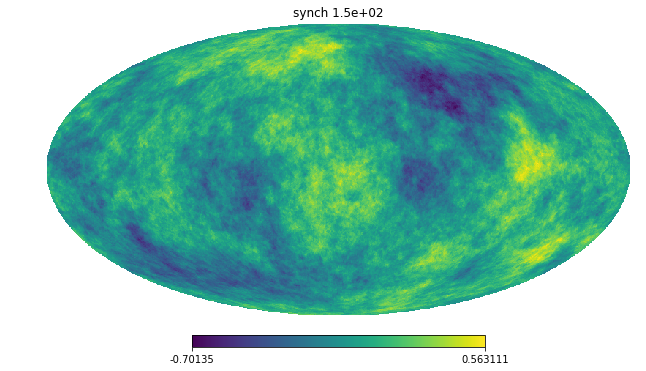

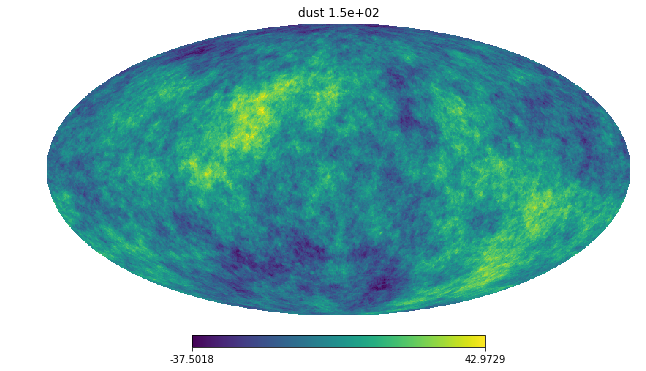

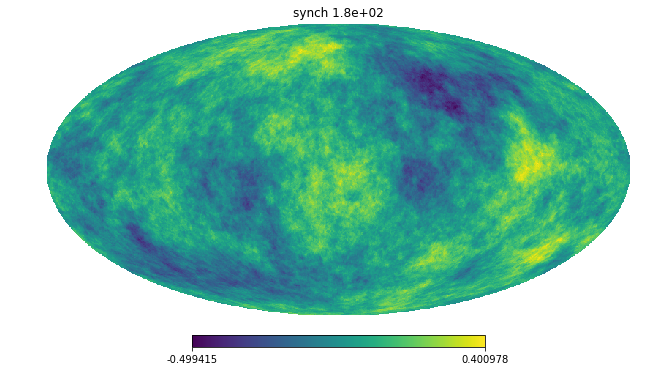

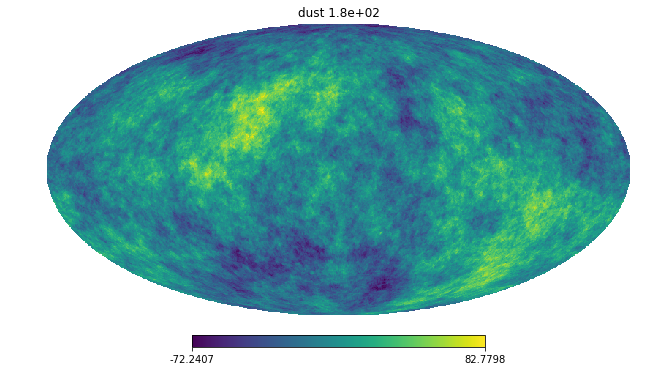

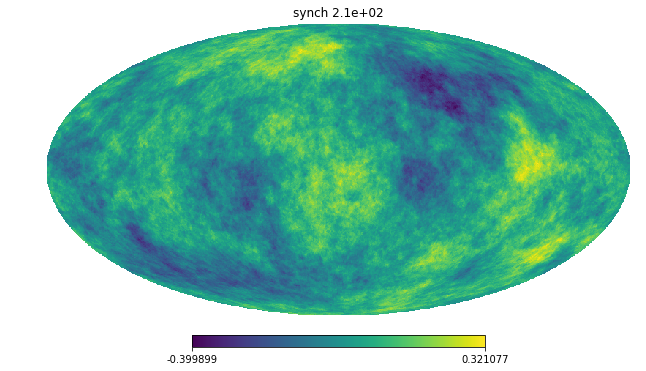

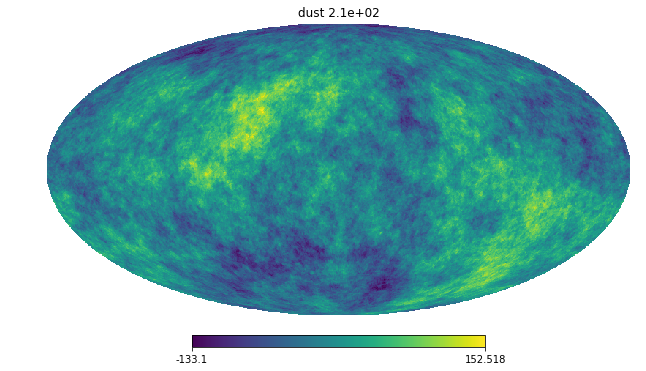

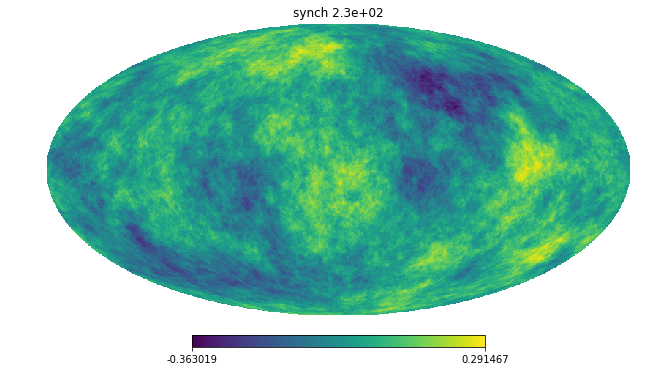

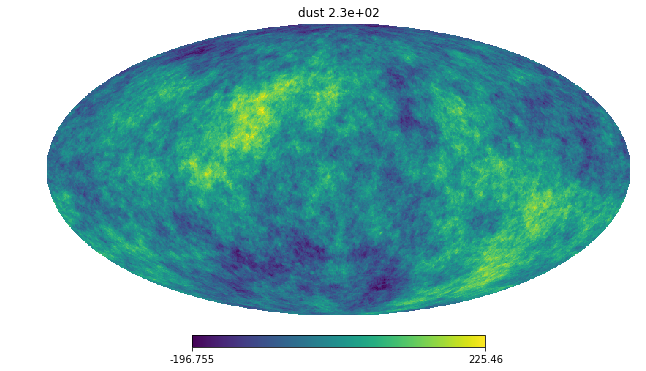

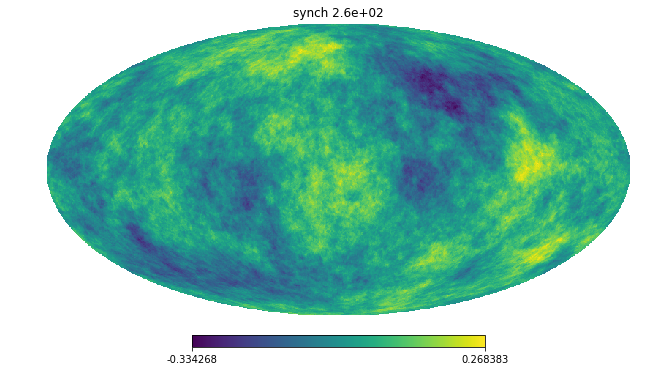

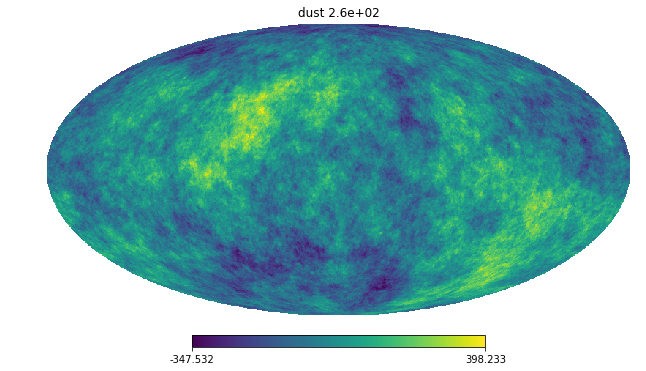

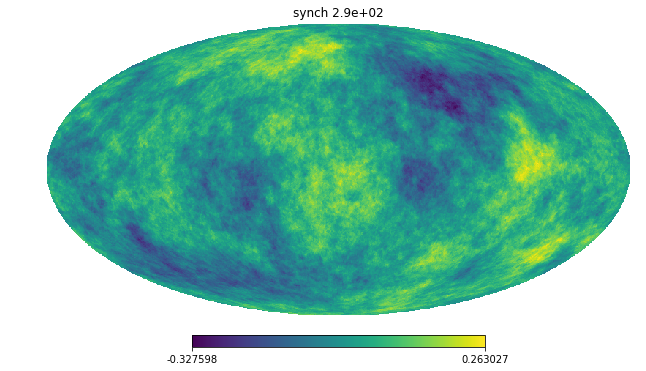

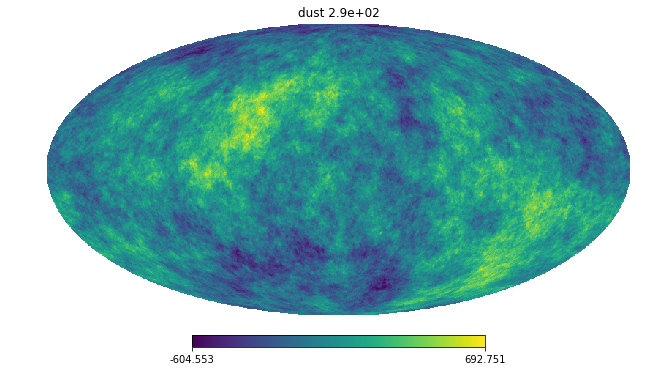

In [40]:
for i in range(len(freqs)):
    freq = freqs[i]*1e-9
    hp.mollview(newmap_s[i],title=f'synch {freq:.3}')
    hp.mollview(newmap_d[i],title=f'dust {freq:.3}')

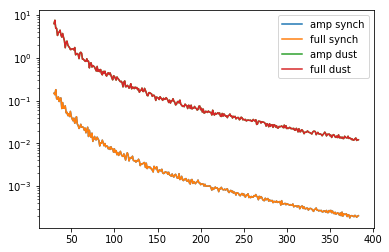

In [49]:
n=2 #corresponding to the pivot frequency of 95 GHz.
semilogy(ells[30:], hp.anafast(ampmap_s)[30:], label='amp synch')
semilogy(ells[30:], hp.anafast(newmap_s[n])[30:], label='full synch')
semilogy(ells[30:], hp.anafast(ampmap_d)[30:], label='amp dust')
semilogy(ells[30:], hp.anafast(newmap_d[n])[30:], label='full dust')
legend()

In [9]:
def cmb(ells, r):
    return r*primo_bb[:len(ells)] + lens_bb[:len(ells)]

In [11]:
def chi2_cmb(params, ells, freqs, data):
    A_s, alpha_s, beta_s, A_d, alpha_d, beta_d, r = params
    long_params = [A_s, alpha_s, beta_s, 0.0, A_d, alpha_d, beta_d, 0.0]

    chi2=0
    model_made = ff.auto0x0_fg(ells, freqs, long_params) + cmb(ells, r)
    #convert to cls for the variance
    data_cls = data*(2*pi)/(ells*(ells+1))
    var = np.zeros((len(freqs),len(ells)))
    for ell in range(len(ells)):
        var[:,ell] = 2/(2*ell+1)
    cosmic_var = var * data_cls**2

    #don't count the first 30 ell in the objective function.
    chi2 = (data[:,30:] - model_made[:,30:])**2 / cosmic_var[:,30:]
    return np.sum(chi2)

In [16]:
input_model = ff.auto0x0_fg(ells, freqs, params) + cmb(ells, 0.01)

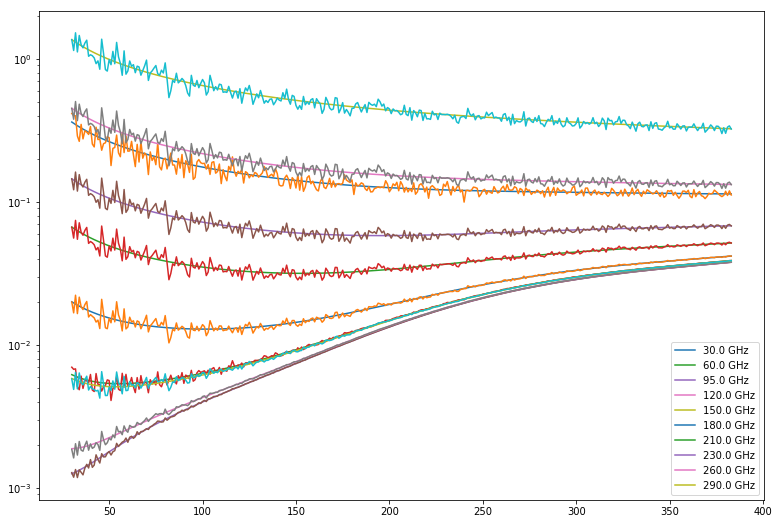

In [25]:
figure(figsize=(13,9))
for i in range(len(freqs)):
    freq=freqs[i]*1e-9
    semilogy(ells[30:], input_model[i][30:], label=f'{freq:.4} GHz')
    semilogy(ells[30:], signal[i][30:])
    legend()

In [12]:
initial_cmb = [A_s, alpha_s, beta_s, A_d, alpha_d, beta_d, r]

In [13]:
for i in params:
    print(type(i))

<class 'numpy.float64'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'numpy.float64'>
<class 'float'>
<class 'float'>
<class 'float'>


In [14]:
start=time.time()
result = minimize(chi2_cmb, initial_cmb, args=(ells, freqs, signal), method='L-BFGS-B')
print(time.time()-start)
print(result)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
../../foreground_functions.py:49: RuntimeWarning: overflow encountered in power
  return (nu/nu0)**(2.+beta[..., np.newaxis])
../../foreground_functions.py:30: RuntimeWarning: overflow encountered in power
  model[2:] = (ells[2:] / 80.)**alpha
../../foreground_functions.py:300: RuntimeWarning: invalid value encountered in multiply
  moment0x0[i] = pcls * sed_scaling[i]**2
../../foreground_functions.py:62: RuntimeWarning: overflow encountered in power
  return nu**(3.+beta[...,np.newaxis])/(eX+1)
../../foreground_functions.py:65: RuntimeWarning: invalid value encountered in true_divide
  return mod_BB(nu, beta, T_dust)/mod_BB(nu0, beta, T_dust)


0.3265039920806885
      fun: nan
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.45339107e+18,  1.84093613e+10, -1.80814133e+10,  9.64283905e+18,
       -1.35811417e+11, -1.56045348e+11, -1.06471912e+11])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 352
      nit: 1
   status: 2
  success: False
        x: array([ 2.25588947e-07, -2.60000000e+00, -3.10000000e+00,  1.56044321e-07,
       -2.60000000e+00,  1.60000000e+00,  1.00000000e-02])


In [169]:
x = result.x
print(chi2_cmb(x, ells, freqs, signal))
print(chi2_cmb([A_s, alpha_s, beta_s, A_d, alpha_d, beta_d, 0.01], ells, freqs, signal))
print(x_cmb)
print('')
print([A_s, alpha_s, beta_s, A_d, alpha_d, beta_d, 0.01])
print('')
print((x_cmb-np.array([A_s, alpha_s, beta_s, A_d, alpha_d, beta_d, 0.01])/np.array([A_s, alpha_s, beta_s, A_d, alpha_d, beta_d, 0.01])*100))

119709.53183316963
1415.8030254021105
[ 1.42791627e-03 -2.58726000e+00 -3.10236375e+00  1.00350217e-03
 -2.59800491e+00  1.60199821e+00  6.43212180e-02]

[2.2573626192909638e-07, -2.6, -3.1, 1.5723188445215814e-07, -2.6, 1.6, 0.01]

[ -99.99857208 -102.58726    -103.10236375  -99.9989965  -102.59800491
  -98.39800179  -99.93567878]


In [167]:
x = result.x
long_x = np.zeros(8)
long_x[:3] = x[:3]
long_x[4:] = x[3:len(x)]
long_x[-1] = 0 #set the gammas to 0 as it doesn't matter what they are.
print(long_x)
fit = ff.auto0x0_fg(ells, freqs, long_x) + cmb(ells, x[-1])
input_model = ff.auto0x0_fg(ells, freqs, params) + cmb(ells, 0.01)

[ 2.15298678e-08 -1.00000000e+00 -3.10000000e+00  0.00000000e+00
  1.36218082e-08 -1.00000000e+00  1.60000000e+00  0.00000000e+00]


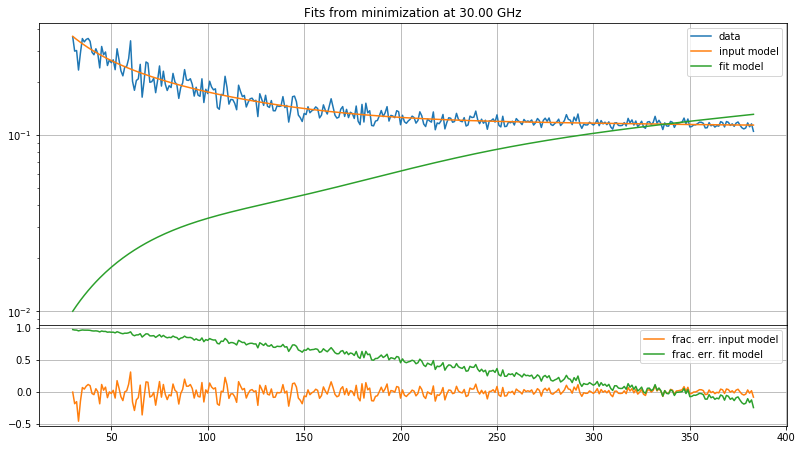

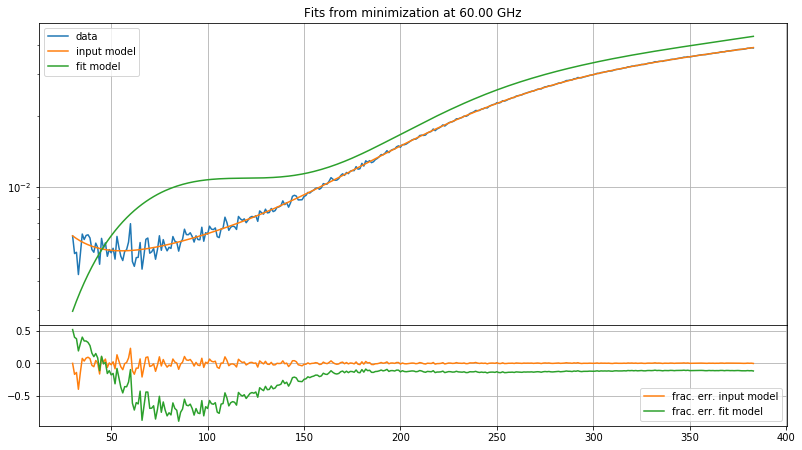

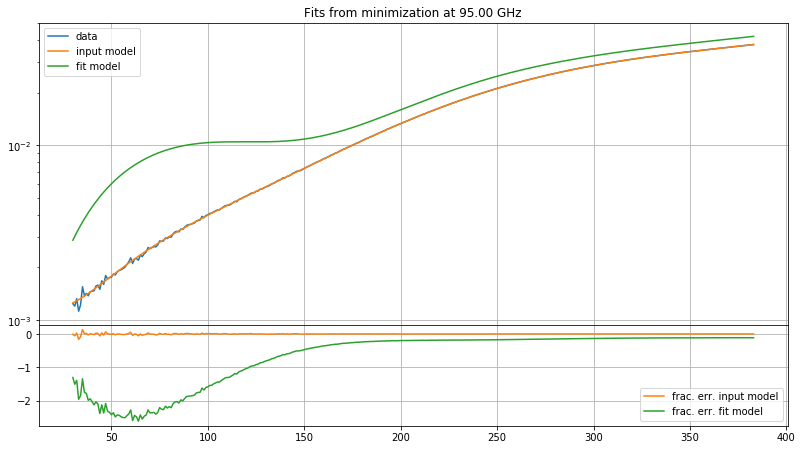

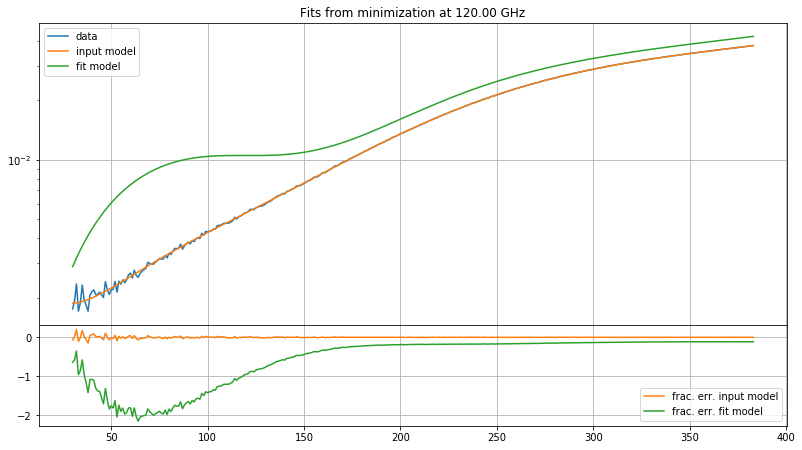

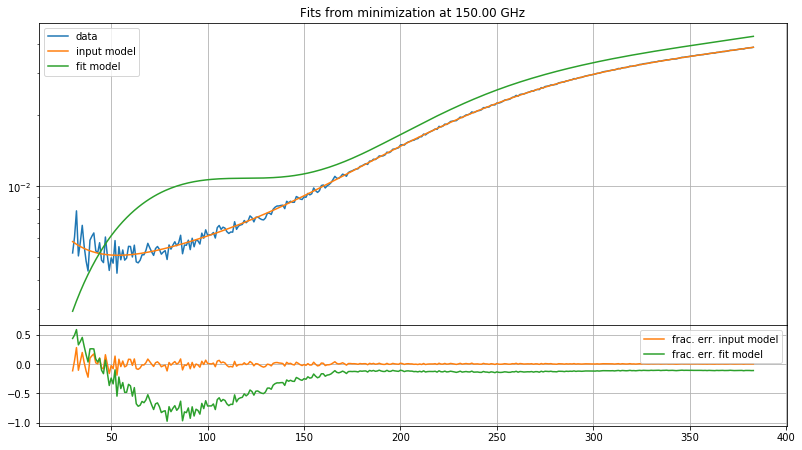

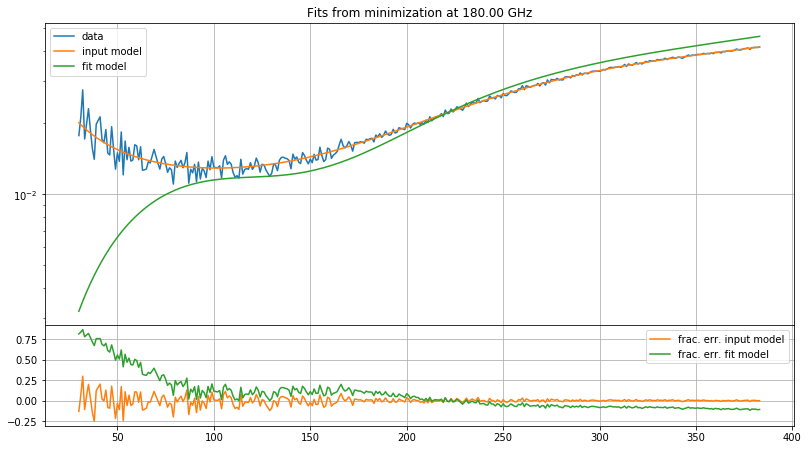

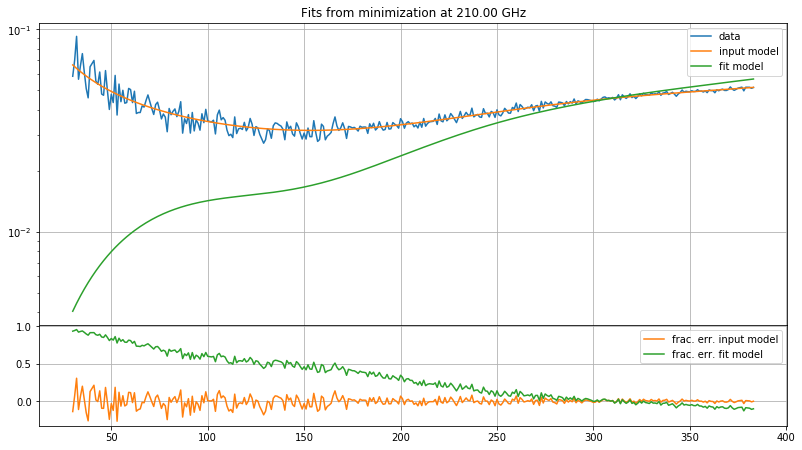

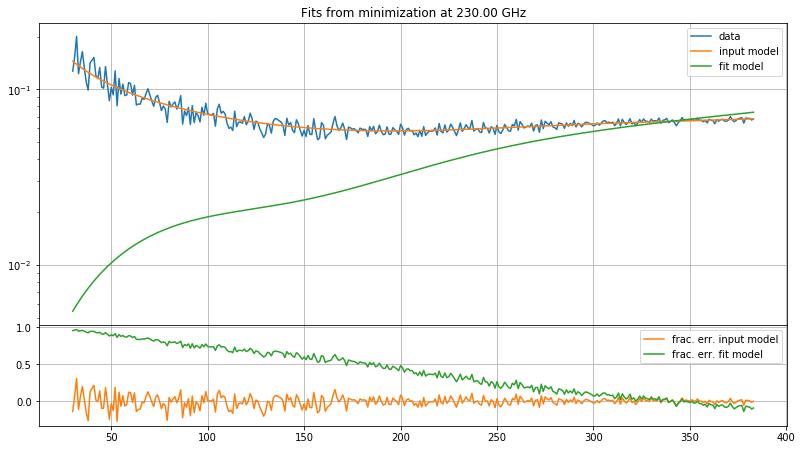

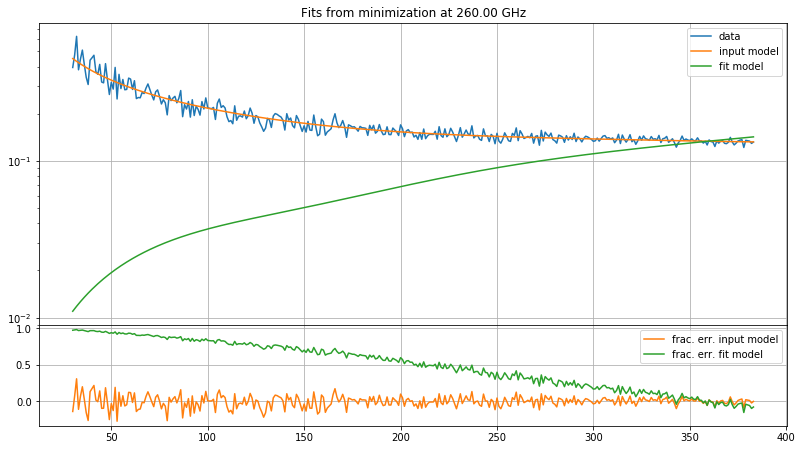

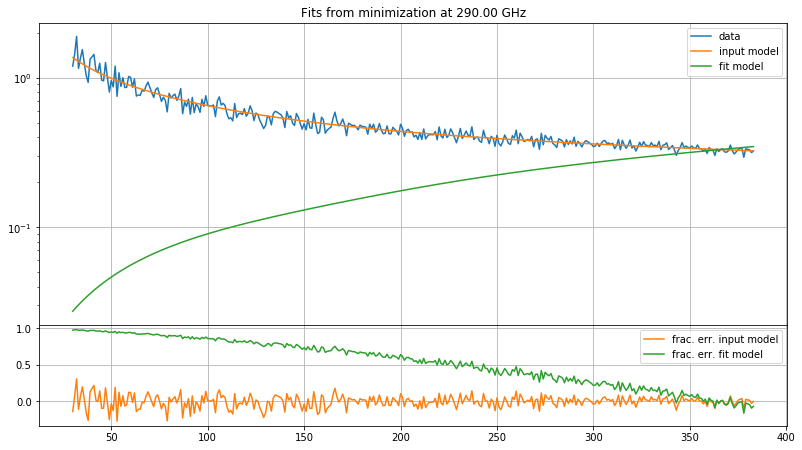

In [168]:
for i in range(len(freqs)):
    fig1 = figure(figsize=(13,7))
    frame1=fig1.add_axes((.1,.3,.8,.6))
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    semilogy(ells[30:], signal[i][30:], label='data')
    semilogy(ells[30:], input_model[i][30:], label='input model', color='C1')
    semilogy(ells[30:], fit[i][30:], label='fit model', color='C2')
    grid()
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    
    
    frame2=fig1.add_axes((.1,.1,.8,.2)) 
    plot(ells[30:], (signal[i][30:]-input_model[i][30:])/signal[i][30:], color='C1', label='frac. err. input model')
    plot(ells[30:], (signal[i][30:]-fit[i][30:])/signal[i][30:], color='C2', label='frac. err. fit model')
    legend()
    grid()

In [44]:
amp_dls_s = hp.anafast(ampmap_s)
amp_dls_d = hp.anafast(ampmap_d)

In [46]:
new_dls_s = hp.anafast(newmap_s[n])
new_dls_d = hp.anafast(newmap_d[n])

In [47]:
amp_dls_d-new_dls_d

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [48]:
amp_dls_s-new_dls_s

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [50]:
#okay, so the SED is really 1 at 95 GHz for both synch and dust, that's good.

In [43]:
SED_s = ff.scale_synch(freqs, beta_s)
SED_d = ff.scale_dust(freqs, beta_d)

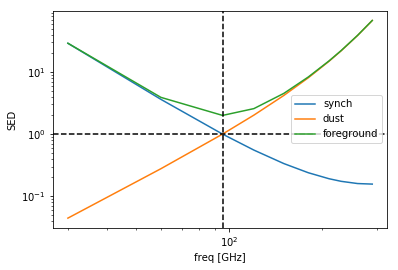

In [48]:
loglog(freqs*1e-9, SED_s, label='synch')
loglog(freqs*1e-9, SED_d, label='dust')
loglog(freqs*1e-9, SED_s+SED_d, label='foreground')
xlabel('freq [GHz]')
ylabel('SED')
axvline(95, color='k', ls='--')
axhline(y=1, color='k', ls='--')
legend()

# check what's going on with the SED that are not normalised to the Planck function

In [45]:
freqs1 = np.linspace(30,3000)*1.e9

In [46]:
SED_normal_s = ff.normed_synch(freqs1, beta_s)
SED_normal_d = ff.normed_dust(freqs1, beta_d)

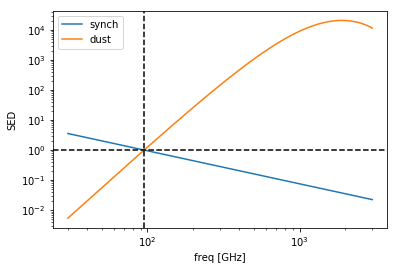

In [47]:
loglog(freqs1*1e-9, SED_normal_s, label='synch')
loglog(freqs1*1e-9, SED_normal_d, label='dust')
xlabel('freq [GHz]')
ylabel('SED')
axvline(95, color='k', ls='--')
axhline(y=1, color='k', ls='--')
legend()

# okay, so these seem to be behaving correctly